<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-in-Data" data-toc-modified-id="Read-in-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read in Data</a></span></li><li><span><a href="#Generate-Models" data-toc-modified-id="Generate-Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate Models</a></span><ul class="toc-item"><li><span><a href="#Support-Vector-Machines" data-toc-modified-id="Support-Vector-Machines-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Support Vector Machines</a></span></li><li><span><a href="#Neural-Network" data-toc-modified-id="Neural-Network-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Neural Network</a></span></li></ul></li><li><span><a href="#Run-Models" data-toc-modified-id="Run-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run Models</a></span></li></ul></div>

In [1]:
import pandas as pd 
import numpy as np 
import plotly.graph_objects as go 
import seaborn as sns 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import tensorflow as tf


## Read in Data

In [2]:
## Read in csv 
tot_df_clean_year = pd.read_csv('model_data.csv', 
                                index_col = ['year', 'ID']).dropna()

## Test and train split for time series
train = tot_df_clean_year.head(
    int(tot_df_clean_year.shape[0] * 0.8 ) 
) 

test = tot_df_clean_year.tail(
    int(tot_df_clean_year.shape[0] * 0.2) 
)

## Split into x and y 
def SplitData(df): 
    y = df.lead_rating 
    x = df.drop('lead_rating', axis = 1) 
    
    return x, y 

train_x, train_y = SplitData(train) 
test_x, test_y = SplitData(test) 

In [ ]:
train_x.head()

## Generate Models 
### Support Vector Machines

In [3]:
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


def SVM_Fit(train_x, train_y, kernel,
            params = [10**x for x in np.arange(-1,3,0.9)]): 
    '''Fit the SVM Machine given the kernel type, parameters, 
    data''' 
    
    if kernel == 'linear': 
        parameters = {'C': params} 
    else: 
        parameters = {'C': params, 
                     'gamma': params} 
    
    cv = TimeSeriesSplit(n_splits = 5) 
    
    model = GridSearchCV(estimator = SVC(kernel = kernel), 
                        param_grid = parameters, 
                        cv = cv, 
                        verbose = 1) 
    
    model.fit(train_x, train_y) 
    return model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

def RandomForestsModel(train_x, train_y): 
    '''Random Forest Model'''
    rf = RandomForestClassifier(random_state = 200) 
    rf.get_params()
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    
    cv = TimeSeriesSplit(n_splits = 5) 
    
    rf_random = RandomizedSearchCV(estimator = rf, 
                              param_distributions = random_grid, 
                              n_iter = 100, cv = cv, verbose = 2, n_jobs = -1)
    
    rf_random.fit(train_x, train_y) 
    return rf_random 

In [72]:
def Predict(fitted_model, test_x, test_y, 
           name):
    '''Prediction Accuracy'''
    prediction = fitted_model.predict(test_x) 
    score = accuracy_score(prediction, test_y) 
    prediction = pd.DataFrame({'prediction_{}'.format(name): prediction})
    print('The {} Model Score is: {}'.format(name, score)) 
    return prediction, score, 

### Neural Network

In [73]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])

model.stop_training = True

In [74]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Run Models

In [75]:
# Category range must go from 0 to 5 instead of -2 to 2
y_train = train_y +1
y_test = test_y +1

model.fit(train_x.to_numpy(), 
          y_train.to_numpy(),
          epochs=1000)


Train on 1450 samples
Epoch 1/1000
1450/1450 [==============================] - 0s 299us/sample - loss: 1.0353 - accuracy: 0.5566
Epoch 2/1000
1450/1450 [==============================] - 0s 60us/sample - loss: 0.9392 - accuracy: 0.6421
Epoch 3/1000
1450/1450 [==============================] - 0s 60us/sample - loss: 0.8986 - accuracy: 0.6552
Epoch 4/1000
1450/1450 [==============================] - 0s 66us/sample - loss: 0.8834 - accuracy: 0.6524
Epoch 5/1000
1450/1450 [==============================] - 0s 63us/sample - loss: 0.8771 - accuracy: 0.6552
Epoch 6/1000
1450/1450 [==============================] - 0s 61us/sample - loss: 0.8693 - accuracy: 0.6538
Epoch 7/1000
1450/1450 [==============================] - 0s 66us/sample - loss: 0.8630 - accuracy: 0.6552
Epoch 8/1000
1450/1450 [==============================] - 0s 60us/sample - loss: 0.8624 - accuracy: 0.6524
Epoch 9/1000
1450/1450 [==============================] - 0s 62us/sample - loss: 0.8519 - accuracy: 0.6559
Epoch 10/1000


1450/1450 [==============================] - 0s 57us/sample - loss: 0.7904 - accuracy: 0.6745
Epoch 152/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7974 - accuracy: 0.6752
Epoch 153/1000
1450/1450 [==============================] - 0s 56us/sample - loss: 0.7959 - accuracy: 0.6676
Epoch 154/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7915 - accuracy: 0.6759
Epoch 155/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7960 - accuracy: 0.6752
Epoch 156/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7917 - accuracy: 0.6724
Epoch 157/1000
1450/1450 [==============================] - 0s 53us/sample - loss: 0.7926 - accuracy: 0.6710
Epoch 158/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7897 - accuracy: 0.6731
Epoch 159/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7923 - accuracy: 0.6724
Epoch 160/1000
1450/1450 [========

1450/1450 [==============================] - 0s 56us/sample - loss: 0.7681 - accuracy: 0.6766
Epoch 302/1000
1450/1450 [==============================] - 0s 58us/sample - loss: 0.7724 - accuracy: 0.6786
Epoch 303/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7668 - accuracy: 0.6772
Epoch 304/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7639 - accuracy: 0.6800
Epoch 305/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.7632 - accuracy: 0.6745
Epoch 306/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.7649 - accuracy: 0.6793
Epoch 307/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7670 - accuracy: 0.6821
Epoch 308/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.7701 - accuracy: 0.6779
Epoch 309/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7652 - accuracy: 0.6821
Epoch 310/1000
1450/1450 [========

1450/1450 [==============================] - 0s 58us/sample - loss: 0.7506 - accuracy: 0.6828
Epoch 452/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7489 - accuracy: 0.6869
Epoch 453/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7464 - accuracy: 0.6938
Epoch 454/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7449 - accuracy: 0.6828
Epoch 455/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7431 - accuracy: 0.6862
Epoch 456/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7484 - accuracy: 0.6807
Epoch 457/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.7426 - accuracy: 0.6841
Epoch 458/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7481 - accuracy: 0.6903
Epoch 459/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7458 - accuracy: 0.6793
Epoch 460/1000
1450/1450 [========

1450/1450 [==============================] - 0s 71us/sample - loss: 0.7394 - accuracy: 0.6807
Epoch 602/1000
1450/1450 [==============================] - 0s 69us/sample - loss: 0.7381 - accuracy: 0.6903
Epoch 603/1000
1450/1450 [==============================] - 0s 69us/sample - loss: 0.7388 - accuracy: 0.6883
Epoch 604/1000
1450/1450 [==============================] - 0s 58us/sample - loss: 0.7264 - accuracy: 0.6869
Epoch 605/1000
1450/1450 [==============================] - 0s 71us/sample - loss: 0.7282 - accuracy: 0.6952
Epoch 606/1000
1450/1450 [==============================] - 0s 71us/sample - loss: 0.7322 - accuracy: 0.6910
Epoch 607/1000
1450/1450 [==============================] - 0s 69us/sample - loss: 0.7360 - accuracy: 0.6883
Epoch 608/1000
1450/1450 [==============================] - 0s 69us/sample - loss: 0.7312 - accuracy: 0.6883
Epoch 609/1000
1450/1450 [==============================] - 0s 69us/sample - loss: 0.7279 - accuracy: 0.6966
Epoch 610/1000
1450/1450 [========

1450/1450 [==============================] - 0s 57us/sample - loss: 0.7168 - accuracy: 0.7007
Epoch 752/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7281 - accuracy: 0.6910
Epoch 753/1000
1450/1450 [==============================] - 0s 58us/sample - loss: 0.7197 - accuracy: 0.6966
Epoch 754/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.7185 - accuracy: 0.7021
Epoch 755/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.7273 - accuracy: 0.6945
Epoch 756/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.7169 - accuracy: 0.6938
Epoch 757/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7272 - accuracy: 0.7000
Epoch 758/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7223 - accuracy: 0.6897
Epoch 759/1000
1450/1450 [==============================] - 0s 59us/sample - loss: 0.7289 - accuracy: 0.6897
Epoch 760/1000
1450/1450 [========

1450/1450 [==============================] - 0s 56us/sample - loss: 0.7161 - accuracy: 0.6931
Epoch 902/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7188 - accuracy: 0.7076
Epoch 903/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.7079 - accuracy: 0.7124
Epoch 904/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.7098 - accuracy: 0.7110
Epoch 905/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.7208 - accuracy: 0.7007
Epoch 906/1000
1450/1450 [==============================] - 0s 54us/sample - loss: 0.6989 - accuracy: 0.7131
Epoch 907/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7132 - accuracy: 0.7007
Epoch 908/1000
1450/1450 [==============================] - 0s 55us/sample - loss: 0.7055 - accuracy: 0.6993
Epoch 909/1000
1450/1450 [==============================] - 0s 56us/sample - loss: 0.7027 - accuracy: 0.7048
Epoch 910/1000
1450/1450 [========

In [78]:
results = model.evaluate(test_x.to_numpy(),  y_test.to_numpy(), verbose=2)
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
tf_predictions = np.argmax(probability_model.predict(test_x.to_numpy()),axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test, tf_predictions)
# np.argmax(predictions,axis=1)
print("Tensorflow",confusion_matrix.numpy(),sep="\n")

362/1 - 0s - loss: 0.8250 - accuracy: 0.6740
Tensorflow
[[ 33  17   7]
 [ 11  97  17]
 [  8  58 114]]


In [29]:
## Make predictions
sigmoid = SVM_Fit(train_x, train_y, 'sigmoid') 
rbf = SVM_Fit(train_x, train_y, 'rbf') 
linear = SVM_Fit(train_x, train_y,'linear')
poly = SVM_Fit(train_x, train_y, 'poly')
rf = RandomForestsModel(train_x, train_y) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [79]:
## SVM Score
sigmoid_predict, sigmoid_score = Predict(sigmoid, test_x, test_y, 'sigmoid') 
lin_predict, lin_score = Predict(linear, test_x, test_y, 'linear') 
poly_predict, poly_score = Predict(poly, test_x, test_y, 'poly') 
rbf_predict, rbf_score = Predict(rbf, test_x, test_y, 'radial')

## TF Score 
tf_score = accuracy_score(predictions, y_test.to_numpy()) 
print('The Neural Network Score is: {}'.format(tf_score)) 

## Random Forest Score
random_predict, random_score = Predict(rf, test_x, test_y, 
                                      'Random Forest')

The sigmoid Model Score is: 0.6906077348066298
The linear Model Score is: 0.6961325966850829
The poly Model Score is: 0.6933701657458563
The radial Model Score is: 0.6988950276243094
The Neural Network Score is: 0.19060773480662985
The Random Forest Model Score is: 0.6961325966850829


/Users/vijayyedidi/opt/anaconda3/envs/credit/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



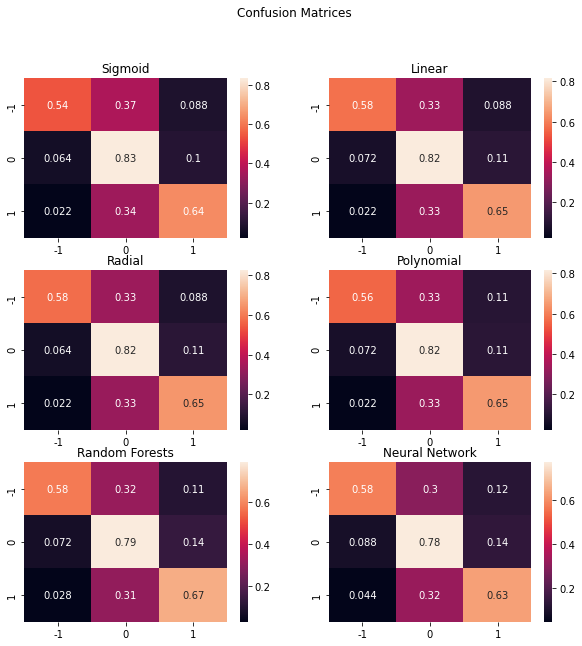

In [88]:
from sklearn.metrics import confusion_matrix

sig_confusion = confusion_matrix(test_y,sigmoid_predict,normalize="true")
lin_confusion = confusion_matrix(test_y,lin_predict,normalize="true")
rbf_confusion = confusion_matrix(test_y,rbf_predict,normalize="true")
random_confusion = confusion_matrix(test_y,random_predict,normalize="true")
tf_confusion = confusion_matrix(y_test, tf_predictions, normalize = 'true')
poly_confusion = confusion_matrix(test_y, poly_predict, normalize = 'true') 

fig, ax = plt.subplots(3, 2, figsize = (10,10)) 
fig.suptitle('Confusion Matrices') 

heatmap = lambda confusion, ax, model_name: sns.heatmap(confusion, ax = ax, annot = True, 
                               xticklabels = [-1,0,1], 
                               yticklabels = [-1,0,1] ).set_title(model_name)  

heatmap(sig_confusion, ax[0,0], 'Sigmoid')
heatmap(lin_confusion, ax[0,1], 'Linear') 
heatmap(rbf_confusion, ax[1,0], 'Radial') 
heatmap(poly_confusion, ax[1,1], 'Polynomial') 
heatmap(random_confusion, ax[2,0], 'Random Forests')
heatmap(tf_confusion, ax[2,1], 'Neural Network') 

fig.show()



In [42]:
fig = go.Figure() 
model_names = ['Sigmoid SVM', 'Radial SVM', 'Linear SVM', 'Polynomial SVM', 'Neural Network']

model_accuracy = [sigmoid_score, rbf_score, lin_score, poly_score, tf_score]

fig.add_trace(go.Bar(x = model_names, 
                    y = model_accuracy, 
                    text = model_accuracy, 
                    textposition = 'auto'))
fig.update_layout(title = 'Model Accuracy Scores Numeric Prediction')

fig.update_yaxes(title_text = 'Accuracy Score') 
fig.update_xaxes(title_text = "Model")
fig.show()